In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import streamlit as st
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

2021-10-26 19:21:10.308 INFO    numexpr.utils: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-10-26 19:21:10.311 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


### <center> **The importance of scaling data before using SVMs** </center>

 <center><a href="https://ibb.co/BCJPnWp"><img src="https://i.ibb.co/HHy2hwS/Screenshot-146.png" alt="Screenshot-146" border="0"></a> </center>

 <center><b>Source</b>: Page 154, Hands-On Machine Learning with Scikit-Learn and TensorFlow - 2
</center>


In [2]:
# def polynomial_kernel(X, Y, d=3):
#         return (np.dot(X, Y.T) + 1)**d

# def gaussian_kernel(X, Y, sigma=1):
#     Y = Y.reshape(-1, 1)
#     return np.exp(-np.linalg.norm(X-Y, axis=1)**2 / (2*(sigma**2)))

def linear_kernel(X, Y):
    return (X @ Y.T).astype(np.float64) # Ensure that you have Python 3.5+ or else @ won't work, for earlier versions use np.matmul

# I cannot get kernels to work so I will only include Hard and Soft Margin SVM in this project

class SVM:
    def __init__(self, kernel=linear_kernel, C = 0):
        # If C is very high then our model is a hard margin problem and vice versa
        # Remember, greater the value of C, the lesser we can 'slack' our margin and thus less outliers can penetrate the margin
        self.kernel = kernel
        self.C = float(C)


    def hard_fit(self, X, y):
        m, n = X.shape[0], X.shape[1]
        y = y.astype(float)
        # H_ij = y_i * y_j * innerproduct(X_i, X_j)
        # The kernel matrix will define the inner product of X in higher dimensions
        kernel_matrix = np.zeros((m, m), dtype=np.float64)
        for i in range(m):
            for j in range(m):
                kernel_matrix[i, j] = self.kernel(X[i], X[j])

        # print(kernel_matrix.dtype)
        # print(np.outer(y, y, ).dtype)
        
        H = np.outer(y, y)*kernel_matrix
        q = -np.ones(shape=(m, 1))
        A = y.reshape(1, -1)
        b = 0.0
        G = np.negative(np.eye(m))
        h = np.zeros(m)

        P = matrix(H)
        q = matrix(q)
        G = matrix(G, (m, m), tc='d')
        h = matrix(h)
        A = matrix(A, (1, m), 'd')
        b = matrix(b)

        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol["x"])
        # print(alphas)
        self.w = np.dot((y * alphas).T, X)[0]
        S = (alphas > 1e-5).flatten()
        self.b = np.mean(y[S] - np.dot(X[S], self.w.reshape(-1,1)))
        self.sv = X[S]
        # print(self.sv)
        print("W:", self.w)
        print("b:", self.b)
        return self.w, self.b


    def soft_fit(self, X, y, C):
        m, n = X.shape[0], X.shape[1]
        kernel_matrix = np.zeros((m, m), dtype=np.float64)

        for i in range(m):
            for j in range(m):
                kernel_matrix[i, j] = self.kernel(X[i], X[j])

        H = np.outer(y, y)*kernel_matrix
        q = -np.ones(shape=(m, 1))
        A = y.reshape(1, -1)
        b = 0.0
        G = np.vstack((np.eye(m)*-1, np.eye(m)))
        h = np.hstack((np.zeros(m), np.ones(m)*C))

        P = matrix(H)
        q = matrix(q)
        G = matrix(G)
        h = matrix(h)
        A = matrix(A, (1, m), 'd')
        b = matrix(b)
        sol = solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol["x"])
        self.S = (self.alphas > 1e-5).flatten()
        self.w = np.dot((y * self.alphas).T, X)[0]
        self.b = np.mean(y[self.S] - np.dot(X[self.S], self.w.reshape(-1,1)))
        self.sv = X[self.S]
        print("W:", self.w)
        print("b:", self.b)                    
        return self.w, self.b
    
    def predict(self, X):
        y_pred = np.dot(X, self.w) + self.b >= 0
        y_pred = np.array(list(map(lambda x: -1 if x==False else 1, y_pred)))
        return y_pred

    def score(self, y_test, y_pred):
        m = y_test.shape[0]
        accuracy = 0
        y_test.ravel()
        for i in range(m):
            if y_pred[i] == y_test[i]:
                accuracy += 1
        accuracy /= X_test.shape[0]
        return accuracy

    def _metrics(self, y_test, y_pred):
        m = y_test.shape[0]
        tp, fp, tn, fn = 0, 0, 0, 0
        for i in range(m):
            if y_test[i] == y_pred[i] and y_test[i]==1: tp+=1
            elif y_test[i]== y_pred[i] and y_test[i]==-1: tn +=1
            elif y_test[i]!=y_pred[i] and y_test[i]==1: fn+=1
            elif y_test[i]!=y_pred[i] and y_test[i]==-1: fp+=1
        precision = tp/(tp + fp)
        recall = tp/(tp + fn) # Recall is also called Sensitivity
        # Specificity is fp / (fp + tn)
        specificity = fp / (fp + tn)

        # F1 Score is the harmonic mean of precision and recall and can be helpful when both of the metrics are important
        f1_score = 2*precision*recall / (precision + recall)
        return tp, fp, tn, fn, precision, recall, specificity, f1_score



    def display_metrics(self, y_test, y_pred):
        accuracy = self.score(y_test, y_pred)
        tp, fp, tn, fn, precision, recall, specificity, f1_score = self._metrics(y_test, y_pred)
        metrics = [["Metric", "Value"],
                   ["Score", accuracy],
                   ["Precision", precision],
                   ["Recall", recall],
                   ["F1 Score", f1_score],
                   ["Specificity", specificity]]
        conf_mat = [["A\P", "P", "N"],
                    ["P", tp, fn],
                    ["N", fp, tn]]
        
        print("Confusion Matrix")
        print(tabulate(conf_mat, tablefmt="fancy_grid"))
        print("Metrics")
        print(tabulate(metrics, tablefmt="fancy_grid", headers="firstrow"))
        return accuracy, np.array([[tp, fn],
                                   [fp, tn]])



# Separate function for plotting
def plot_clf(clf, X_train, y_train, x_plt, title='Support Vector Machine Classifier', training=True):
    a = -clf.w[0]/clf.w[1]
    y_plt = a * x_plt - clf.b/clf.w[1]
    margin_width = 1 / np.sqrt(np.sum((clf.w) ** 2))
    y_down = y_plt - np.sqrt(1 + a ** 2)*margin_width
    y_up = y_plt + np.sqrt(1 + a ** 2)*margin_width
    plt.figure(1, figsize=(5,4))
    sep_hyp, = plt.plot(x_plt, y_plt, 'k--')
    pos_margin,= plt.plot(x_plt, y_up, 'g--'), 
    neg_margin, = plt.plot(x_plt, y_down, 'g--')
    # plt.ylim((y_lim[0], y_lim[1]))
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.ravel(), s=25, cmap='Set1')
    if training==True:
        sup_vec = plt.scatter(clf.sv[:, 0], clf.sv[:, 1], c='orange')
        plt.legend([sep_hyp, sup_vec], ['Sep. Hyperplane', 'Support Vectors'], loc='best')
    else:
        plt.legend([sep_hyp], ['Sep. Hyperplane'], loc='best')
        
    plt.title(title)
    plt.show()

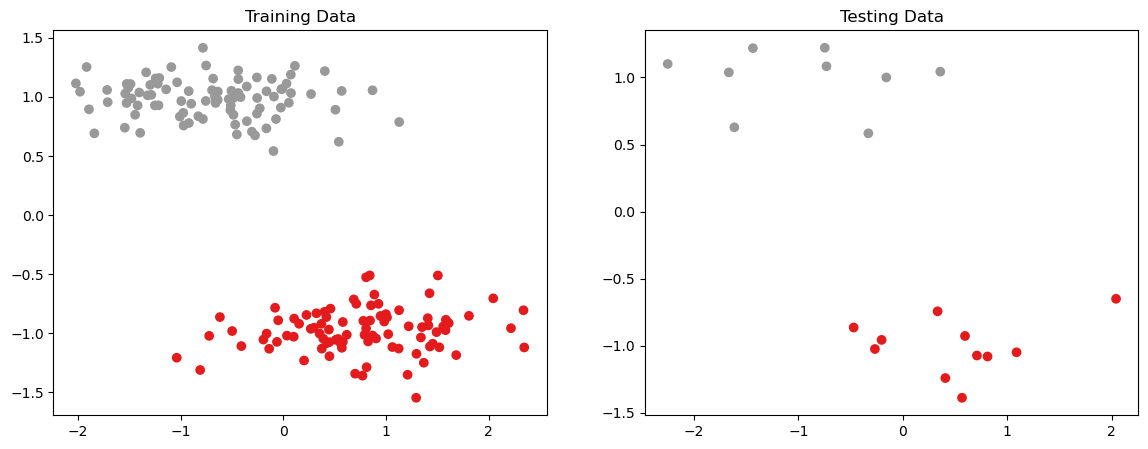

In [3]:
# make_blobs generates isotropic Gaussian blobs for clustering.
scaler = StandardScaler(copy=True)
num_samples = 200
X, y = make_blobs(n_samples=num_samples, centers=2, random_state=10, cluster_std=1.4, n_features = 2)
X = scaler.fit_transform(X)
y[y == 0] = -1  
y = y.reshape((-1, 1))
X_train, X_test = X[:-num_samples//10, :], X[-num_samples//10:, :]
y_train, y_test = y[:-num_samples//10, :], y[-num_samples//10:, :]

fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].set_title("Training Data")
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train.flatten(), cmap='Set1')
ax[1].set_title("Testing Data")
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test.flatten(), cmap='Set1')
plt.show()

In [4]:
clf_hard = SVM(kernel=linear_kernel)
clf_hard.hard_fit(X_train, y_train)
w_hard, b_hard = clf_hard.w, clf_hard.b
y_pred_hard = clf_hard.predict(X_test)

clf_soft = SVM(kernel=linear_kernel)
clf_soft.soft_fit(X_train, y_train, 0.5)
w_soft, b_soft = clf_soft.w, clf_soft.b
y_pred_soft = clf_soft.predict(X_test)

W: [-0.40204401  1.65978009]
b: 0.1876397658441804
W: [-0.24408846  1.46786827]
b: 0.09830117297727346


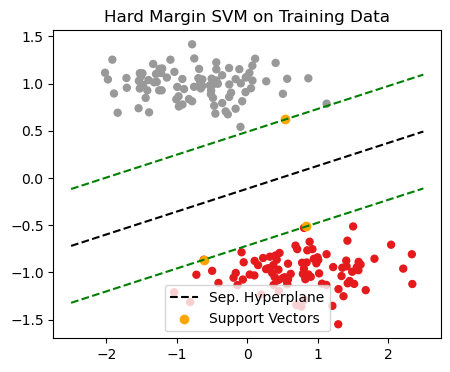

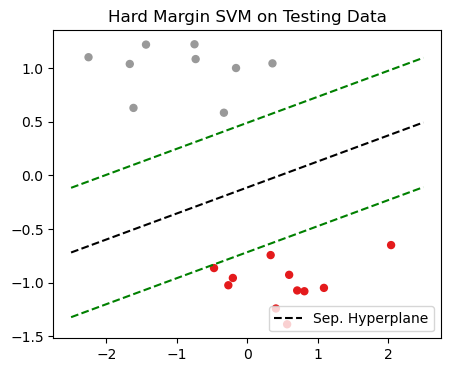

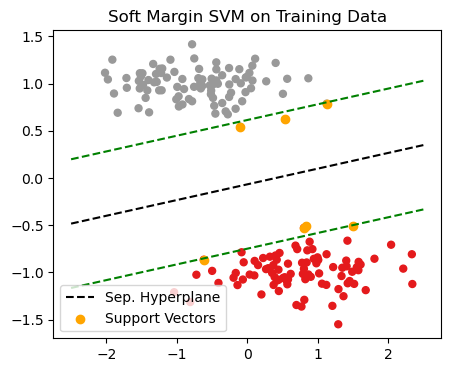

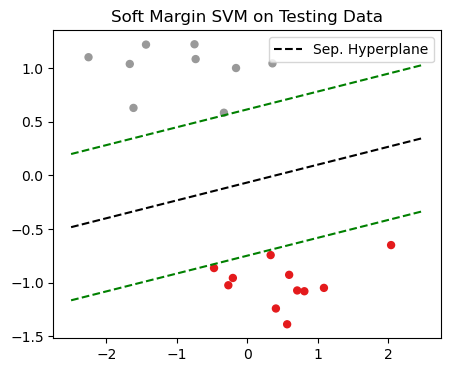

In [5]:
x_plt = np.linspace(-2.5, 2.5)

plot_clf(clf_hard, X_train, y_train, x_plt, "Hard Margin SVM on Training Data")
plot_clf(clf_hard, X_test, y_test, x_plt, "Hard Margin SVM on Testing Data", training=False)

plot_clf(clf_soft, X_train, y_train, x_plt, "Soft Margin SVM on Training Data")
plot_clf(clf_soft, X_test, y_test, x_plt, "Soft Margin SVM on Testing Data", training=False)

In [6]:
accuracy_hard, confusion_matrix_hard = clf_hard.display_metrics(y_test, y_pred_hard)
accuracy_soft,  confusion_matrix_soft = clf_soft.display_metrics(y_test, y_pred_soft)

Confusion Matrix
╒═════╤═══╤════╕
│ A\P │ P │ N  │
├─────┼───┼────┤
│ P   │ 9 │ 0  │
├─────┼───┼────┤
│ N   │ 0 │ 11 │
╘═════╧═══╧════╛
Metrics
╒═════════════╤═════════╕
│ Metric      │   Value │
╞═════════════╪═════════╡
│ Score       │       1 │
├─────────────┼─────────┤
│ Precision   │       1 │
├─────────────┼─────────┤
│ Recall      │       1 │
├─────────────┼─────────┤
│ F1 Score    │       1 │
├─────────────┼─────────┤
│ Specificity │       0 │
╘═════════════╧═════════╛
Confusion Matrix
╒═════╤═══╤════╕
│ A\P │ P │ N  │
├─────┼───┼────┤
│ P   │ 9 │ 0  │
├─────┼───┼────┤
│ N   │ 0 │ 11 │
╘═════╧═══╧════╛
Metrics
╒═════════════╤═════════╕
│ Metric      │   Value │
╞═════════════╪═════════╡
│ Score       │       1 │
├─────────────┼─────────┤
│ Precision   │       1 │
├─────────────┼─────────┤
│ Recall      │       1 │
├─────────────┼─────────┤
│ F1 Score    │       1 │
├─────────────┼─────────┤
│ Specificity │       0 │
╘═════════════╧═════════╛


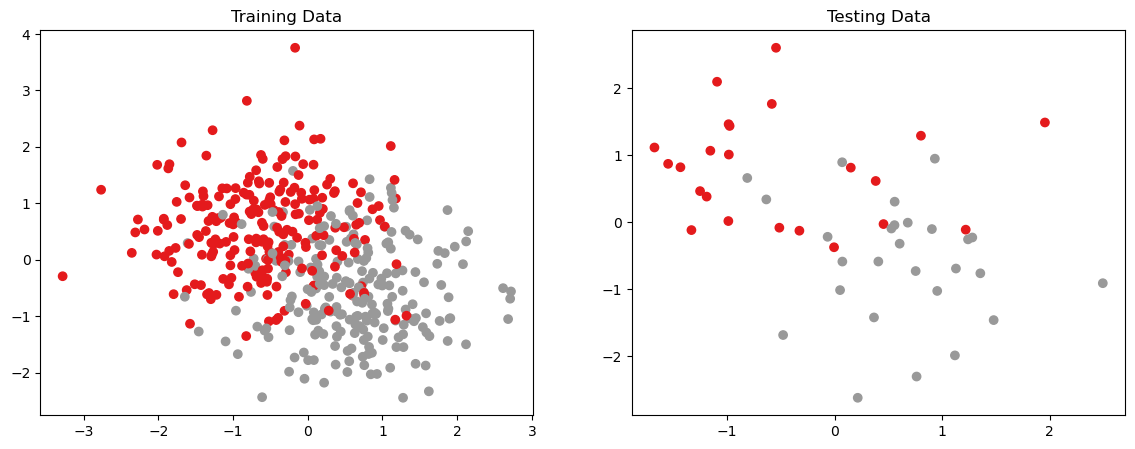

In [7]:
num_samples = 500
X, y = make_blobs(n_samples=num_samples, centers=2, random_state=42, cluster_std=5, n_features = 2)
X = scaler.fit_transform(X)
y[y == 0] = -1  
y = y.reshape((-1, 1))
X_train, X_test = X[:-num_samples//10, :], X[-num_samples//10:, :]
y_train, y_test = y[:-num_samples//10, :], y[-num_samples//10:, :]

fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].set_title("Training Data")
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train.flatten(), cmap='Set1')
ax[1].set_title("Testing Data")
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test.flatten(), cmap='Set1')
plt.show()

In [8]:
clf_hard.hard_fit(X_train, y_train)
w_hard, b_hard = clf_hard.w, clf_hard.b
y_pred_hard = clf_hard.predict(X_test)

clf_soft.soft_fit(X_train, y_train, 100)
w_soft, b_soft = clf_soft.w, clf_soft.b
y_pred_soft = clf_soft.predict(X_test)

W: [ 1.76429749e-05 -6.89029694e-05]
b: -0.008889075166945256
W: [ 1.33319269 -1.08120701]
b: 0.01634537754846724


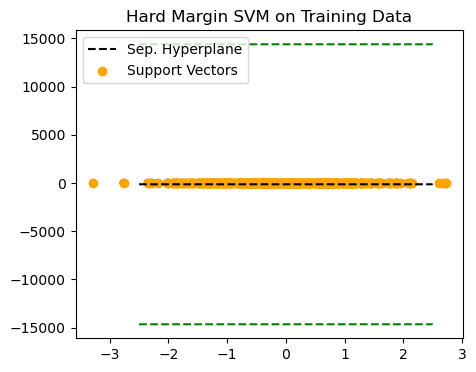

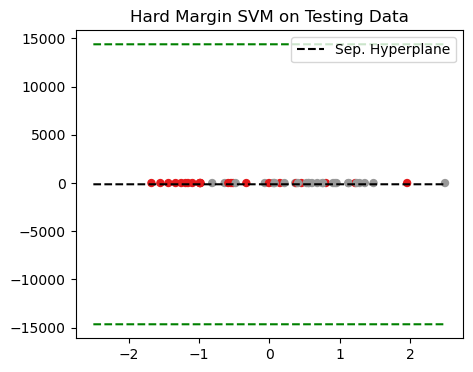

Clearly, Hard Margin classifier fails here because we cannot create a linear hyperplane perfectly separating the two classes


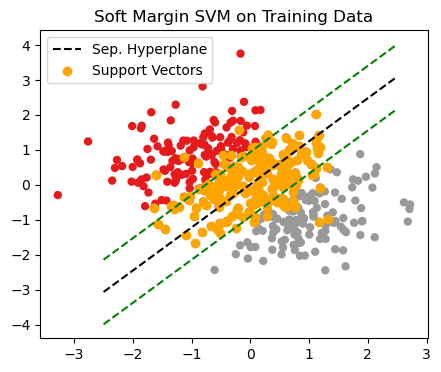

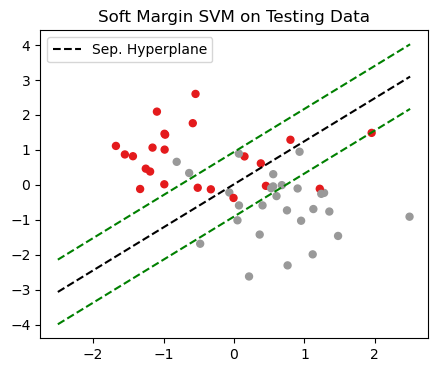

In [9]:
x_plt = np.linspace(-2.5, 2.5)

plot_clf(clf_hard, X_train, y_train, x_plt, "Hard Margin SVM on Training Data")
plot_clf(clf_hard, X_test, y_test, x_plt, "Hard Margin SVM on Testing Data", training=False)
print("Clearly, Hard Margin classifier fails here because we cannot create a linear hyperplane perfectly separating the two classes")
plot_clf(clf_soft, X_train, y_train, x_plt, "Soft Margin SVM on Training Data")
plot_clf(clf_soft, X_test, y_test, x_plt, "Soft Margin SVM on Testing Data", training=False)

In [10]:
# accuracy_hard, confusion_matrix_hard = clf_hard.display_metrics(y_test, y_pred_hard) this will give division by zero error
accuracy_soft,  confusion_matrix_soft = clf_soft.display_metrics(y_test, y_pred_soft)

Confusion Matrix
╒═════╤════╤════╕
│ A\P │ P  │ N  │
├─────┼────┼────┤
│ P   │ 24 │ 3  │
├─────┼────┼────┤
│ N   │ 4  │ 19 │
╘═════╧════╧════╛
Metrics
╒═════════════╤══════════╕
│ Metric      │    Value │
╞═════════════╪══════════╡
│ Score       │ 0.86     │
├─────────────┼──────────┤
│ Precision   │ 0.857143 │
├─────────────┼──────────┤
│ Recall      │ 0.888889 │
├─────────────┼──────────┤
│ F1 Score    │ 0.872727 │
├─────────────┼──────────┤
│ Specificity │ 0.173913 │
╘═════════════╧══════════╛
